In [2]:
import pandas as pd
import numpy as np
import gensim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


/home/karthick/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('train.csv', names=['label', 'review'])
df = df.iloc[:int(len(df)*0.05), :]
df['label'] -= 1


In [144]:
tokenizer = RegexpTokenizer(r'[a-z]+')

stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
             "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
             'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',
             'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
             'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
             'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
             'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than',
             'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o',
             're', 've', 'y', 'ma' 'st', 'nd', 'rd', 'th', "you'll", 'dr', 'mr', 'mrs']

In [ ]:
def tokenize(sent):
    """Generate list of tokens for each sentence

    Args:
        sent (str): review

    Returns:
        list[str]: list of tokens
    """
    txt = sent.lower()
    tokens = tokenizer.tokenize(txt)
    tokens = [word for word in tokens if not word in stopwords]
    return tokens


df['tokens'] = df['review'].apply(tokenize)


In [255]:
W2V_VEC_DIM = 50
W2V_WINDOW = 5
W2V_MIN_COUNT = 3
W2V_EPOCHS = 10

model = gensim.models.Word2Vec(
    vector_size=W2V_VEC_DIM, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
model.build_vocab(df['tokens'])
model.train(df['tokens'], total_examples=model.corpus_count, epochs=W2V_EPOCHS)

(17526641, 19057290)

In [256]:
def sent_vec(sent):
    """Calculate average w2v word embedding for a sentence

    Args:
        sent (list[str]): list of tokens for sentence

    Returns:
        ndarray: average word embedding
    """
    wv_vec = np.zeros(W2V_VEC_DIM)
    count = 0

    for word in sent:
        if word in model.wv:
            count += 1
            wv_vec += model.wv[word]
    
    if count > 0:
        wv_vec /= count
    return wv_vec

df['vector'] = df['tokens'].apply(sent_vec)

In [403]:
class SentimentDataset(Dataset):
    def __init__(self, vector, label):
        self.vector = vector
        self.label = label

    def __len__(self):
        return len(self.vector)
    
    def __getitem__(self, idx):
        return self.vector[idx], self.label[idx]

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim_2, output_dim=1):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_2)
        self.relu2 = nn.ReLU()
        # self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        # out = self.dropout(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out





In [ ]:
x = torch.cuda.FloatTensor(df['vector'])
y = torch.cuda.FloatTensor(df['label']).unsqueeze(1)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42)

train_data = SentimentDataset(x_train, y_train)
val_data = SentimentDataset(x_val, y_val)


In [ ]:
def binary_acc(y_pred, y_test):
    """Calculate accuracy 

    Args:
        y_pred (Tensor): Predicted results
        y_test (Tensor): Ground truth

    Returns:
        Tensor: Sum of correct predictions
    """
    y_h = torch.round(y_pred)
    crct_results = (y_h == y_test).sum()
    return crct_results

In [445]:
CLF_BATCH_SIZE = 128
CLF_HIDDEN_LAYER1_DIM = 16
CLF_HIDDEN_LAYER2_DIM = 32
CLF_LEARNING_RATE = 5e-5
CLF_EPOCHS = 500

train_loader = DataLoader(train_data, batch_size=CLF_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=CLF_BATCH_SIZE, shuffle=False)


In [446]:
model = Classifier(input_dim=W2V_VEC_DIM, hidden_dim=CLF_HIDDEN_LAYER1_DIM, hidden_dim_2=CLF_HIDDEN_LAYER2_DIM).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CLF_LEARNING_RATE)

In [447]:
history = defaultdict(list)

best_val_loss = 100
for epoch in range(CLF_EPOCHS):
    print(f'Epoch: {epoch+1}')
    # train
    model.train()
    train_loss = 0
    train_acc = 0

    for vecs, labels in train_loader:
        # forward

        vecs = vecs.to(device)
        labels = labels.to(device)

        outputs = model(vecs)
        loss = criterion(outputs, labels)
        acc = binary_acc(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.float()
        train_acc += acc.float()

    train_loss /= len(train_data)
    train_acc /= len(train_data)

    # valid
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for vecs, labels in val_loader:

            vecs = vecs.to(device)
            labels = labels.to(device)

            outputs = model(vecs)
            loss = criterion(outputs, labels)
            acc = binary_acc(outputs, labels)

            val_loss += loss.float()
            val_acc += acc.float()

    val_loss /= len(val_data)
    val_acc /= len(val_data)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(
        f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}')

Epoch: 1
Train loss: 0.0054358248598873615, Train acc: 0.4837053418159485, Val loss: 0.005423406139016151, Val acc: 0.4826785624027252
Epoch: 2
Train loss: 0.005341668613255024, Train acc: 0.486339271068573, Val loss: 0.0053050825372338295, Val acc: 0.5078571438789368
Epoch: 3
Train loss: 0.005193284712731838, Train acc: 0.6151339411735535, Val loss: 0.005117247346788645, Val acc: 0.7055357098579407
Epoch: 4
Train loss: 0.004969654139131308, Train acc: 0.740223228931427, Val loss: 0.004855029750615358, Val acc: 0.7758928537368774
Epoch: 5
Train loss: 0.004682968836277723, Train acc: 0.7891071438789368, Val loss: 0.004543319344520569, Val acc: 0.8080357313156128
Epoch: 6
Train loss: 0.00436497014015913, Train acc: 0.8136160373687744, Val loss: 0.004218671936541796, Val acc: 0.8257142901420593
Epoch: 7
Train loss: 0.004042333923280239, Train acc: 0.8250446319580078, Val loss: 0.0039001761469990015, Val acc: 0.835357129573822
Epoch: 8
Train loss: 0.00373635720461607, Train acc: 0.83553570

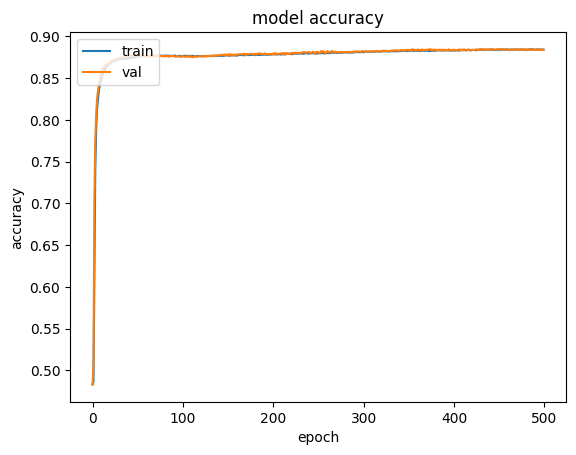

In [450]:
plt.plot(torch.tensor(history['train_acc']).detach().cpu().numpy())
plt.plot(torch.tensor(history['val_acc']).detach().cpu().numpy())
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

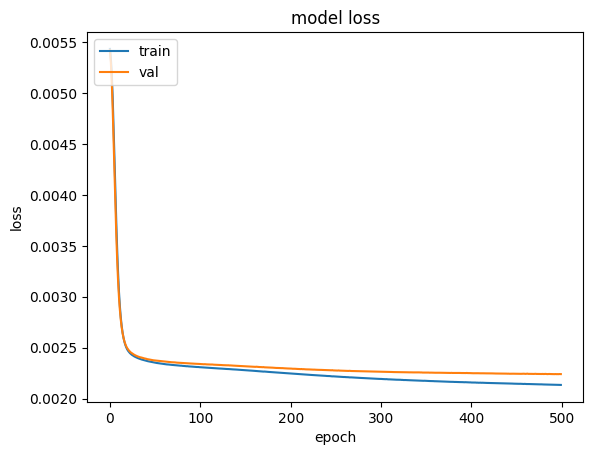

In [451]:
plt.plot(torch.tensor(history['train_loss']).detach().cpu().numpy())
plt.plot(torch.tensor(history['val_loss']).detach().cpu().numpy())
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()